In [38]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import pandas as pd

from sklearn.model_selection import train_test_split

In [39]:
import os
import pandas as pd
import nltk
import numpy as np
import gensim
from sklearn import svm
from sklearn.model_selection import train_test_split


In [40]:
x_train = np.array((400,10000),dtype=int)
y_train = np.array((400,4),dtype=int)
y_harry = []
y_delagala = []
y_jona = []
y_stefanie = []
y_eileen = []

harry =  pd.read_csv('data/harry_marquez.csv',header=None)
for i in range(0,harry.shape[0]):
    y_harry.append([1,0,0,0])

delagala =pd.read_csv('data/delaGala.csv',header=None)
for i in range(0,delagala.shape[0]):
     y_delagala.append([0,1,0,0])


jona =pd.read_csv('data/jonathan_jimmy.csv')
for i in range(0,jona.shape[0]):
    y_jona.append([0,0,1,0])

stefanie =pd.read_csv('data/stefanie.csv',header=None)
for i in range(0,stefanie.shape[0]):
    y_stefanie.append([0,0,0,1])


In [41]:
x_data = np.concatenate((harry,delagala,jona,stefanie))
y_data = np.concatenate((y_harry,y_delagala,y_jona,y_stefanie))
x_data

array([[195, 194, 196, ..., 176, 187, 187],
       [135, 134, 135, ..., 158, 158, 154],
       [192, 193, 194, ...,  66,  66,  67],
       ...,
       [138, 120, 117, ...,   2,   4,   4],
       [144, 128, 128, ...,   2,   3,   3],
       [140, 122, 125, ...,   2,   0,   0]], dtype=int64)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [43]:
# Convolutional capa 1.
filtro1 = 15          # Convolution filters are 5 x 5 pixels.
num_filtros1 = 20       # There are 16 of these filters.

# Convolutional capa 2.
filtro2 = 15          # Convolution filters are 5 x 5 pixels.
num_filtros2 = 40         # There are 36 of these filters.

# Fully-connected capa.
fc_size = 128             # Number of neurons in fully-connected capa.

In [44]:
#dimensiones de la data
img_size = 100
#dimension del vector que guarda la imagen
img_size_flat = img_size * img_size
#tupla de height y width de la imagen
img_shape = (img_size,img_size)
#numero de clases 
num_classes = 4
#numero de canales
num_canales = 1

In [45]:
def new_pesos(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [46]:
def flatten_capa(capa):
    # Get the shape of the input capa.
    capa_shape = capa.get_shape()
    num_features = capa_shape[1:4].num_elements()
    capa_flat = tf.reshape(capa, [-1, num_features])
    return capa_flat, num_features

In [47]:
def new_conv_capa(input,             
                   num_input_canales, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):  

    shape = [filter_size, filter_size, num_input_canales, num_filters]

    pesos = new_pesos(shape=shape)

    biases = new_biases(length=num_filters)
    capa = tf.nn.conv2d(input=input,
                         filter=pesos,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    capa += biases

    if use_pooling:
        capa = tf.nn.max_pool(value=capa,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    capa = tf.nn.relu(capa)
    return capa, pesos

In [48]:

def new_fc_capa(input,          
                 num_inputs,     
                 num_outputs,   
                 use_relu=True): 
    pesos = new_pesos(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

  
    capa = tf.matmul(input, pesos) + biases

    # Use ReLU?
    if use_relu:
        capa = tf.nn.relu(capa)

    return capa

In [49]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_canales])

In [50]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [51]:
capa_conv1, pesos_conv1 = \
    new_conv_capa(input=x_image,
                   num_input_canales=num_canales,
                   filter_size=filtro1,
                   num_filters=num_filtros1,
                   use_pooling=True)

In [52]:
capa_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 50, 50, 20) dtype=float32>

In [53]:
capa_conv2, pesos_conv2 = \
    new_conv_capa(input=capa_conv1,
                   num_input_canales=num_filtros1,
                   filter_size=filtro2,
                   num_filters=num_filtros2,
                   use_pooling=True)

In [54]:
capa_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 25, 25, 40) dtype=float32>

In [55]:
capa_flat, num_features = flatten_capa(capa_conv2)

In [56]:
capa_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 25000) dtype=float32>

In [57]:
num_features

25000

In [58]:

capa_fc1 = new_fc_capa(input=capa_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [59]:
capa_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [60]:

capa_fc2 = new_fc_capa(input=capa_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [61]:
capa_fc2 

<tf.Tensor 'add_7:0' shape=(?, 4) dtype=float32>

In [62]:
y_pred = tf.nn.softmax(capa_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)


In [63]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [64]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=capa_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# ahora creamos el grafo en tensorflow
# saver = tf.train.Saver()
session = tf.Session()
ops = tf.global_variables_initializer()
session.run(ops)
# saver.save(session, './cnn',global_step=1000)

In [65]:
train_batch_size = 50

In [66]:
# y = np.transpose(y)
y_train.shape

(270, 4)

In [67]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,total_iterations + num_iterations):
        feed_dict_train = {x: X_train, y_true:y_train}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 1 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            msg = "iteracion: {0:>6}, Exactitud de entrenamiento: {1:>6.1%}"

            print(msg.format(i + 1, acc))
      
       
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    

In [68]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)    
    images = X_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = y_pred_cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [69]:
def plot_confusion_matrix(cls_pred,cls_true):

    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [70]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    num_test = X_test.shape[0]
    cls_pred = np.zeros(shape=num_test, dtype=np.int)   
   

    feed_dict = {x: X_test,y_true: y_test}
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict)

    print(cls_pred)
    cls_true = []
    for i in range(0,y_test.shape[0]):
        cls_true.append(np.argmax(y_test[i]))
    print(cls_true)

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

#     # Print the accuracy.
    msg = "Exactitud del entrenamiento: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred,cls_true)

[0 1 1 1 1 1 2 1 0 1 1 0 1 1 2 2 1 2 0 1 1 1 1 2 1 1 0 1 2 0 2 0 0 1 1 1 2
 1 0 1 0 0 2 1 2 1 2 1 2 1 2 2 1 1 1 1 0 2 2 0 2 2 0 2 1 1 1 1 0 1 2 1 0 2
 2 0 1 0 1 1 1 2 1 0 0 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1
 1 1 1 1 2 1 1 1 0 1 1 0 0 1 0 1 0 1 2 1 0 2]
[0, 2, 2, 0, 0, 0, 1, 3, 3, 3, 3, 0, 2, 3, 1, 2, 1, 2, 0, 1, 0, 3, 3, 2, 2, 3, 0, 2, 1, 0, 1, 0, 0, 1, 2, 3, 0, 3, 0, 3, 2, 3, 1, 1, 1, 3, 0, 3, 1, 1, 1, 0, 1, 0, 3, 3, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 3, 1, 0, 2, 2, 3, 0, 1, 1, 0, 0, 0, 2, 3, 3, 3, 2, 0, 0, 1, 1, 3, 0, 2, 2, 3, 0, 3, 1, 3, 2, 1, 2, 3, 3, 2, 0, 1, 1, 0, 0, 2, 0, 0, 1, 3, 3, 2, 2, 2, 3, 3, 0, 0, 2, 2, 2, 1, 1, 0, 2, 0, 3, 1, 2, 1, 1]
Exactitud del entrenamiento: 33.8% (45 / 133)
Confusion Matrix:
[[24  8  7  0]
 [ 2 16 14  0]
 [ 6 18  5  0]
 [ 2 30  1  0]]


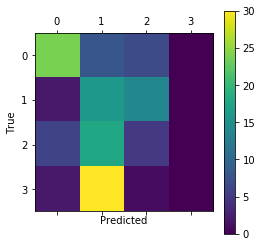

In [71]:
print_test_accuracy(False,True)

In [85]:
optimize(num_iterations=5)

iteracion:      6, Exactitud de entrenamiento:  71.5%
iteracion:      7, Exactitud de entrenamiento:  83.3%
iteracion:      8, Exactitud de entrenamiento:  93.7%
iteracion:      9, Exactitud de entrenamiento:  98.1%
iteracion:     10, Exactitud de entrenamiento:  98.9%
Time usage: 0:05:42


[0 2 2 0 0 0 1 3 3 3 3 0 2 3 1 2 1 2 0 1 0 3 3 2 2 3 0 2 1 0 1 0 0 1 2 3 0
 3 0 3 2 3 1 1 1 3 0 3 1 1 1 0 1 0 3 3 0 0 0 2 0 1 0 1 3 1 3 1 0 2 2 3 0 1
 1 0 0 0 2 3 3 3 2 0 0 1 1 3 0 2 2 3 2 3 1 3 2 1 2 3 3 2 0 1 1 0 0 2 0 0 1
 3 3 2 2 2 3 3 0 0 2 0 2 1 1 0 2 0 3 1 2 1 1]
[0, 2, 2, 0, 0, 0, 1, 3, 3, 3, 3, 0, 2, 3, 1, 2, 1, 2, 0, 1, 0, 3, 3, 2, 2, 3, 0, 2, 1, 0, 1, 0, 0, 1, 2, 3, 0, 3, 0, 3, 2, 3, 1, 1, 1, 3, 0, 3, 1, 1, 1, 0, 1, 0, 3, 3, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 3, 1, 0, 2, 2, 3, 0, 1, 1, 0, 0, 0, 2, 3, 3, 3, 2, 0, 0, 1, 1, 3, 0, 2, 2, 3, 0, 3, 1, 3, 2, 1, 2, 3, 3, 2, 0, 1, 1, 0, 0, 2, 0, 0, 1, 3, 3, 2, 2, 2, 3, 3, 0, 0, 2, 2, 2, 1, 1, 0, 2, 0, 3, 1, 2, 1, 1]
Exactitud del entrenamiento: 98.5% (131 / 133)
Confusion Matrix:
[[38  0  1  0]
 [ 0 32  0  0]
 [ 1  0 28  0]
 [ 0  0  0 33]]


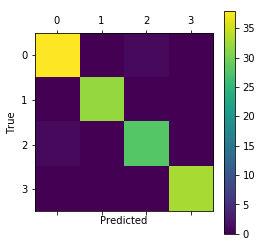

In [86]:
print_test_accuracy(False,True)

In [74]:
def plot_conv_pesos(pesos, input_channel=0):
    w = session.run(pesos)
    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

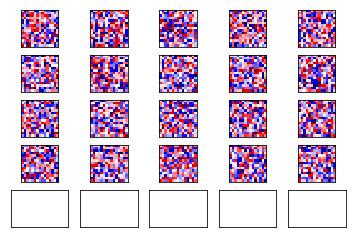

In [75]:
plot_conv_pesos(pesos=pesos_conv1)

In [76]:
plot_conv_pesos(pesos=pesos_conv2, input_channel=0)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [78]:
clf = RandomForestClassifier(n_estimators=900, max_depth=10,random_state=0)
clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
print(accuracy_score(y_test, yPred))

0.9774436090225563


In [79]:
def y_clean(y):
    cls_true = []
    for i in range(0,y.shape[0]):
        cls_true.append(np.argmax(y[i]))
    return cls_true

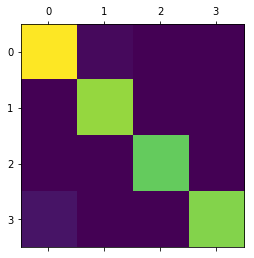

In [80]:
cm = confusion_matrix(y_true=np.array(y_clean(y_test)),
                          y_pred=np.array(y_clean(yPred)))
plt.matshow(cm)


In [81]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.98148148, 1.        , 0.98148148, 0.98148148, 1.        ])

In [82]:
from sklearn.svm import SVC

In [83]:
svc = SVC(gamma='auto')
svc.fit(X_train, y_clean(y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
labels = {0:'Harry',1:'DelaGala',2:'Jona',3:'stefanie'}
colores = {0:[51,152,255],1:[231,52,255],2:[51,255,81],3:[234,51,255]}
labels[0]

'Harry'

In [87]:
import cv2

In [134]:
lista = []
for i in range(1,11):
    nombre = "pruebas/image%04i.jpg" %i    
    img  = cv2.imread(nombre,0) # el valor 0 indica escala de grises, sin ese valor, aparecería en colores
    img2 = cv2.resize(img,(100,100))
    img = np.resize(img2,(1,10000))
    lista.append(img)
    
lista = np.resize(lista,(7,10000))
predict = session.run([y_pred],feed_dict={x:lista})



In [136]:
predict = np.array(predict)
predict = np.resize(predict,(7,4))
predict = np.array(y_clean(predict))
for i in range(0,predict.shape[0]):
    print(labels[predict[i]])



Harry
Harry
Harry
Harry
Harry
Harry
Harry
Harry
Harry
Harry
Harry
